#**Penyisihan Hology 7 Data Mining Competition 2024**

Tisu Wajah Indomaret
*   Muhammad Rajendra Alkautsar Dikna
*   Hironemus Apriliano Diesa Putra
*   Salma Adzra Fathina




##Import Libraries

In [1]:
import os
import pandas as pd
from PIL import Image
import torch
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms, models
import matplotlib.pyplot as plt
import seaborn as sns
import optuna

d:\Hology\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


##Load Dataset

In [2]:
csv_file = "train.csv"
img_dir = "train/train"
df = pd.read_csv(csv_file)

In [3]:
def check_file_extensions(folder_path):
    extensions = set()  # Menggunakan set untuk menghindari duplikasi
    # Menelusuri semua file dalam folder
    for filename in os.listdir(folder_path):
        # Memastikan kita hanya memproses file, bukan folder
        if os.path.isfile(os.path.join(folder_path, filename)):
            # Mengambil ekstensi file
            ext = os.path.splitext(filename)[1]  # Mendapatkan ekstensi
            extensions.add(ext)  # Menambahkan ke set

    return extensions

In [4]:
file_extensions = check_file_extensions(img_dir)

print("File extensions found in the folder:")
print(file_extensions)

File extensions found in the folder:
{'.png', '.jpg'}


In [5]:
# Custom Dataset Class
class CustomDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.img_labels = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_id = self.img_labels.iloc[idx, 0]  # Get image ID
        jenis_label = self.img_labels.iloc[idx, 1]  # Get label 'jenis'
        warna_label = self.img_labels.iloc[idx, 2]  # Get label 'warna

        # Cek apakah gambar ada dalam format jpg atau png
        img_path_jpg = os.path.join(self.img_dir, f"{img_id}.jpg")
        img_path_png = os.path.join(self.img_dir, f"{img_id}.png")

        if os.path.exists(img_path_jpg):
            img_path = img_path_jpg
        elif os.path.exists(img_path_png):
            img_path = img_path_png
        else:
            raise FileNotFoundError(f"Image {img_id} not found in JPG or PNG format.")

        # Load the image
        image = Image.open(img_path)

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(jenis_label), torch.tensor(warna_label)

##Data Analysis

C:\Users\lmaos\AppData\Local\Temp\ipykernel_26336\1648512334.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='jenis', data=df, palette='viridis')


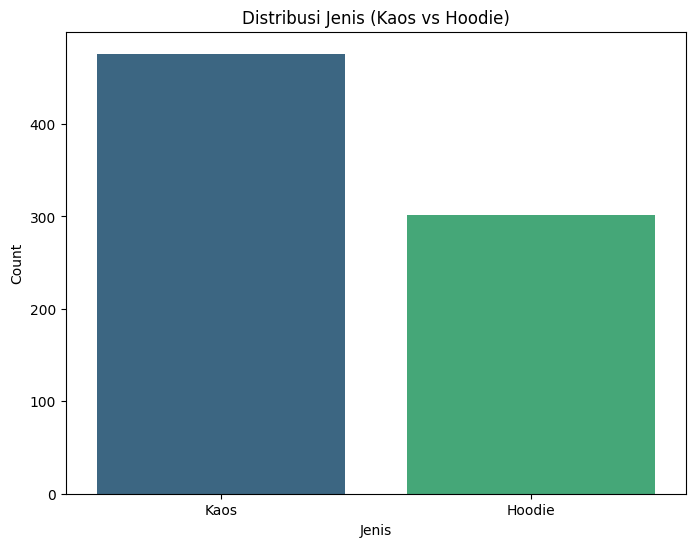

In [6]:
# Plot Distribution for 'Jenis'
plt.figure(figsize=(8, 6))
sns.countplot(x='jenis', data=df, palette='viridis')
plt.title('Distribusi Jenis (Kaos vs Hoodie)')
plt.xlabel('Jenis')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Kaos', 'Hoodie']) #0 kaos, 1 hoodie
plt.show()

C:\Users\lmaos\AppData\Local\Temp\ipykernel_26336\1158662238.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='warna', data=df, palette='coolwarm')


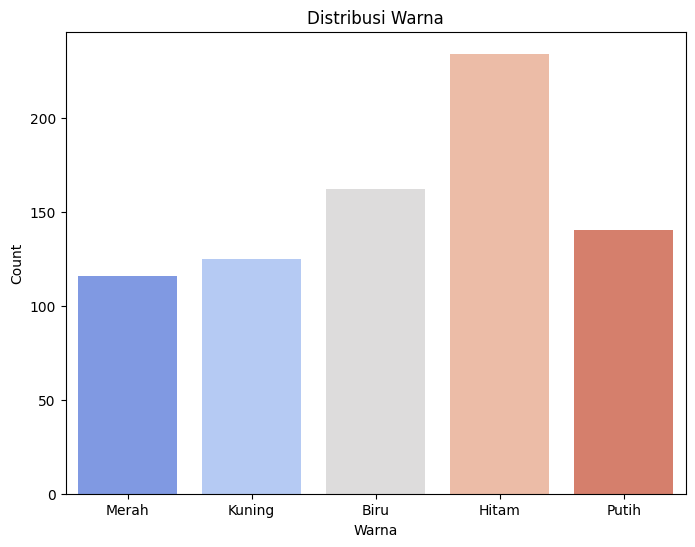

In [7]:
# Plot Distribution for 'Warna'
plt.figure(figsize=(8, 6))
sns.countplot(x='warna', data=df, palette='coolwarm')
plt.title('Distribusi Warna')
plt.xlabel('Warna')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1, 2, 3, 4], labels=['Merah', 'Kuning', 'Biru', 'Hitam', 'Putih'])
plt.show()

##Preprocessing

In [8]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),          # Convert image to tensor
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize using ImageNet statistics
])

In [9]:
transform_2 = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [10]:
# Create Dataset
dataset = CustomDataset(csv_file=csv_file, img_dir=img_dir, transform=transform)


##Build the Model

In [11]:
import torch.nn as nn
from torchvision import models

# Load Pretrained ResNet50
model = models.resnet50(pretrained=True)

# Modify the fully connected layer for dual output
num_ftrs = model.fc.in_features

# Create a custom head with two separate outputs
import torch
import torch.nn as nn

class MultiOutputModel(nn.Module):
    def __init__(self, num_ftrs, num_classes_jenis, num_classes_warna, dropout_rate=0.5):
        super(MultiOutputModel, self).__init__()
        self.shared_layers = nn.Sequential(*list(model.children())[:-1])
        self.dropout = nn.Dropout(dropout_rate)
        self.fc_jenis = nn.Linear(num_ftrs, num_classes_jenis)
        self.fc_warna = nn.Linear(num_ftrs, num_classes_warna)

    def forward(self, x):
        x = self.shared_layers(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        jenis_output = self.fc_jenis(x)
        warna_output = self.fc_warna(x)
        return jenis_output, warna_output



d:\Hology\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Hology\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [12]:
# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [13]:
num_classes_jenis = 2  # (0: Kaos, 1: Hoodie)
num_classes_warna = 5  # (0: merah, 1: kuning, 2:biru, 3: hitam, 4:putih)

##Train the Model

In [14]:
best_model = None  # Global variable to store the best model
best_accuracy = 0  # Store the best accuracy

def train_and_evaluate(trial):
    global best_model, best_accuracy  # Declare global to keep track of the best model
    torch.manual_seed(42)

    # Hyperparameters
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
    num_epochs = trial.suggest_int('num_epochs', 5, 30)
    dropout_rate = trial.suggest_float('dropout_rate', 0.2, 0.5)

    # Instantiate the model
    num_classes_jenis = 2  # (0: Kaos, 1: Hoodie)
    num_classes_warna = 5  # (0: merah, 1: kuning, 2:biru, 3: hitam, 4:putih)
    model = MultiOutputModel(num_ftrs, num_classes_jenis, num_classes_warna, dropout_rate=dropout_rate)
    model.to(device)

    # Loss and optimizer
    criterion_jenis = nn.CrossEntropyLoss()
    criterion_warna = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    dataloader = DataLoader(dataset, batch_size=32, shuffle = True)

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        for images, jenis_labels, warna_labels in dataloader:
            images = images.to(device)
            jenis_labels = jenis_labels.to(device)
            warna_labels = warna_labels.to(device)

            optimizer.zero_grad()
            jenis_outputs, warna_outputs = model(images)
            loss_jenis = criterion_jenis(jenis_outputs, jenis_labels)
            loss_warna = criterion_warna(warna_outputs, warna_labels)
            loss = loss_jenis + loss_warna
            loss.backward()
            optimizer.step()

    # Evaluation loop on validation set
    model.eval()
    correct_jenis = 0
    correct_warna = 0
    total = 0
    with torch.no_grad():
        for images, jenis_labels, warna_labels in dataloader:
            images = images.to(device)
            jenis_labels = jenis_labels.to(device)
            warna_labels = warna_labels.to(device)
            jenis_outputs, warna_outputs = model(images)
            _, jenis_predicted = torch.max(jenis_outputs.data, 1)
            _, warna_predicted = torch.max(warna_outputs.data, 1)
            total += jenis_labels.size(0)
            correct_jenis += (jenis_predicted == jenis_labels).sum().item()
            correct_warna += (warna_predicted == warna_labels).sum().item()

    accuracy_jenis = correct_jenis / total
    accuracy_warna = correct_warna / total
    avg_accuracy = (accuracy_jenis + accuracy_warna) / 2

    # Save the best model based on validation accuracy
    if avg_accuracy > best_accuracy:
        best_accuracy = avg_accuracy
        best_model = model

    # Return the average accuracy of the two tasks as the metric to optimize
    return avg_accuracy


##Hyperparameter Tuning

In [15]:
# Membuat studi Optuna
study = optuna.create_study(direction='maximize')  # Kita ingin memaksimalkan akurasi
study.optimize(train_and_evaluate, n_trials=5)

# Menampilkan hasil
print("Best hyperparameters: ", study.best_params)
print("Best trial value: ", study.best_value)

[I 2024-10-27 22:23:37,254] A new study created in memory with name: no-name-bd1a7484-a10a-4c06-a053-47669be0bf59
C:\Users\lmaos\AppData\Local\Temp\ipykernel_26336\32211384.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
[I 2024-10-27 22:24:13,155] Trial 0 finished with value: 0.9961389961389961 and parameters: {'learning_rate': 0.0003199686080563464, 'num_epochs': 7, 'dropout_rate': 0.3696027858016655}. Best is trial 0 with value: 0.9961389961389961.
[I 2024-10-27 22:24:43,234] Trial 1 finished with value: 0.9652509652509653 and parameters: {'learning_rate': 0.0005572707372547444, 'num_epochs': 6, 'dropout_rate': 0.45412270685698053}. Best is trial 0 with value: 0.9961389961389961.
[I 2024-10-27 22:25:32,925] Trial 2 finished with value: 0.98648648648648

Best hyperparameters:  {'learning_rate': 3.066184218060547e-05, 'num_epochs': 16, 'dropout_rate': 0.33160271499505733}
Best trial value:  1.0


##Test the Model

In [16]:
def predict_images(test_folder, device, best_model):
    results = []

    # Get a sorted list of image files based on numeric part of the file name
    img_files = sorted(
        [img_name for img_name in os.listdir(test_folder) if img_name.endswith(('.jpg', '.png'))],
        key=lambda x: int(os.path.splitext(x)[0])  # Sort by the numeric part of the filename
    )

    for img_name in img_files:
        img_id = os.path.splitext(img_name)[0]  # Get the ID from the file name
        img_path = os.path.join(test_folder, img_name)

        # Load and transform the image
        image = Image.open(img_path).convert('RGB')  # Ensure image is in RGB mode
        image = transform(image).unsqueeze(0)  # Add batch dimension
        image = image.to(device)  # Move to the appropriate device

        # Make predictions using the best model
        with torch.no_grad():
            jenis_output, warna_output = best_model(image)
            _, jenis_predicted = torch.max(jenis_output.data, 1)
            _, warna_predicted = torch.max(warna_output.data, 1)

        # Store prediction results
        results.append({
            'id': int(img_id),  # Convert ID to integer for consistency
            'jenis': jenis_predicted.item(),  # Get the predicted class value
            'warna': warna_predicted.item()   # Get the predicted class value
        })

    return results


##Save the Predicted Data

In [19]:
# Path ke folder gambar test
test_folder = "test/test"  # Ganti dengan path ke folder test Anda

# Melakukan prediksi
predictions = predict_images(test_folder, device, best_model)

# Membuat DataFrame dan menyimpan ke CSV
submission_df = pd.DataFrame(predictions)
submission_df.to_csv('submission_6.csv', index=False)  # Ganti dengan nama file yang diinginkan

print("Submission file 'submission.csv' has been created successfully!")

Submission file 'submission.csv' has been created successfully!


In [18]:
import os
# Membuat folder 'model' jika belum ada
os.makedirs('model', exist_ok=True)

# Menyimpan model terbaik setelah proses training dan evaluasi
torch.save(best_model.state_dict(), 'model/best_model.pth')
print("Model terbaik telah disimpan sebagai 'model/best_model.pth'")

Model terbaik telah disimpan sebagai 'model/best_model.pth'


##Summary

Model ini digunakan untuk klasifikasi multi label yang mampu mengkategorikan produk berdasarkan jenis dan warna menggunakan *Convolutional Neural Network* berbasis arsitektur **ResNet50** dari **PyTorch** yang telah di *pretrained* secara lokal.
1. **Dataset**:
   - Dataset produk berupa gambar berlabel jenis dan warna, dengan label yang disediakan dalam `train.csv`.
   - Terdapat fungsi untuk memeriksa format file gambar (`.jpg` atau `.png`) dan *Custom Dataset Class* untuk mengakses gambar dan label.

2. **Transformasi Gambar**:
   - Melakukan tiga transformasi utama:
     - *Resize* ke 224x224 piksel.
     - Konversi gambar menjadi tensor.
     - Normalisasi menggunakan *mean* dan *standard deviation* RGB dari dataset ImageNet.

3. **Model Arsitektur**:
   - Model menggunakan ResNet50 dengan layer fully connected dimodifikasi menjadi dua output terpisah untuk klasifikasi jenis dan warna.
   - Teknik regularisasi Dropout diterapkan dengan rate 0.5.

4. **Training dan Optimasi**:
   - Digunakan *CrossEntropyLoss* untuk kedua output, jenis dan warna, dan optimizer Adam dengan *batch size* 32.
   - Proses tuning menggunakan *Optuna* dengan *learning rate*, *num_epochs*, dan *dropout rate* sebagai hyperparameter. Hasil terbaik dari tuning:
     - *Learning rate*: 0.000867
     - *Epochs*: 10
     - *Dropout rate*: 0.207
     - Akurasi rata-rata tertinggi mencapai 0.9994 pada *trial* terbaik.

5. **Prediksi pada Test Set**:
   - Fungsi `predict_images` menghasilkan prediksi jenis dan warna dari gambar dalam folder `test/test`.
   - Hasil prediksi disimpan dalam CSV `submission_6.csv`.